<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Sam/Sartorius_segmentation_kaggle_Sam_v026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Sartorius - Cell Instance Segmentation
##Detect single neuronal cells in microscopy images

Project HSLU Master IT Digitalization & Sustainability
Module: Machine Learning and Data Science
* Samuel Hurni
* Pradanendr Sudev  
* Chakravarti Devanandini

This code was programmed from Samuel Hurni and should just be used for individual grading of Samuel Hurni. The other two group members did their work in a separate collab with another approach.

## 0.1 General information and references

Used Third party Libraries:
* Pytorch
* TQDM
* Pandas
* Numpy
* gdown
* Matplotlib

Used Thid party Imports:
* Auxiliary functions metric: "https://www.kaggle.com/code/theoviel/competition-metric-map-iou
* Auxiliary functions for encoding and decoding the mask: "https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn"

Used model source code and imports:
Facebook DETR: https://github.com/facebookresearch/detr



References to Turtorials / Code documantation:
* Pytorch documentation: https://pytorch.org/docs/stable/index.html
* Pytorch Turtorial: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Kaggel dataset for ideas: https://www.kaggle.com/code/enzou3/sartorius-mask-r-cnn




  **Important:**
  **Please check the Hyperparameters for this File because this allows you for example to run the project with limited images or load pretrained models**

## 0.2 About the project

Link to the project as follow: https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation




Main objectives:

This Kaggle competition is about creating a computer program to identify and outline individual nerve cells in microscope images. These nerve cells are important for studying brain diseases like Alzheimer's and brain tumors, which are major health problems worldwide. Typically, scientists look at these cells using a microscope, but finding each cell in the images can be tough and takes a lot of time. Doing this accurately could help find new treatments for these diseases.

The challenge is that current methods aren't very good at recognizing these nerve cells, especially a kind called neuroblastoma cells, which look very different from other cells and are hard to identify with existing tools.

Sartorius, a company that supports science and medicine research, is sponsoring this competition. They want participants to develop a method that can automatically and precisely identify different types of nerve cells in images. This would be a big step forward in neurological research, making it easier for scientists to understand how diseases affect nerve cells and possibly leading to the discovery of new medications.



Dataset:

The Dataset containa at arround 600 images for training and 200 images for testing. the goal would be to train a model whoch is able to segment neuronal cells.


The ground truth data to the images for training consist several meta data which includes also the masks for training the segmentation problem. These are specified field of ecah datapoint:


* _id - unique identifier for object_

* _annotation - run length encoded pixels for the identified neuronal cell_

* _width - source image width_

* _height - source image height_

* _cell_type - the cell line_

* _plate_time - time plate was created_

* _sample_date - date sample was created_

* _sample_id - sample identifier_

* _elapsed_timedelta - time since first image taken of sample_



In [ ]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

fatal: destination path 'detr' already exists and is not an empty directory.


# 1.Preparations: Loading Dataset and install or import Packages

## 1.1 Install adn import third party packages / functions

In this chapter we install the third party packages which maybe are not installed in the prebuild google collab or on your local system

* Tqdm --> progress bar
* gdown --> Import google drive package


In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
from detr.models.segmentation import PostProcessPanoptic, PostProcessSegm
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

## 1.2 Define custom functions for this Project:

In this chapter we are defining custom functions which we are using throughout this project:

* `show_train_time` function to show the time how long the coputation of the model takes
* `folder_content` function to display what is inside a folder
* `check_drop_image_existence` function to drop from the label dataset images which are not in the file system
* `accuracy_fn` function for multi-label calssification problems
* `plot_loss_values` for plotting the loss and accuracy to detect under or overfitting
* `model_rating` gives back the rating of the model with accuracy and score for a given dataloader dataset
* `make_pred` make predictions with a model based on test data
* `combine_models_predictions_2` combines the results of two models with the size of 4 and 13 labels to a result of 17 labels
* `make_pred_combined` make predctions for the combined approach  with two models, one for the weather labels and another for the other labelsm

* AverageMeter - class for averaging loss,metric,etc over epochs

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_loss_values_old(results_train: List[Dict[str, List[float]]], results_valid: List[Dict[str, List[float]]], losses: List[str]):
    """
    Dynamically plot the loss values based on provided configuration to show if the model is overfitting or underfitting,
    adapting to new data structures where each loss type per epoch is a list of values, and only the last value in the list should be used.

    Args:
    results_train (List[Dict[str, List[float]]]): List of dictionaries with training loss values per epoch.
    results_valid (List[Dict[str, List[float]]]): List of dictionaries with validation loss values per epoch.
    losses (List[str]): List of loss types to plot.
    """
    # Convert lists of dictionaries to dictionaries of lists, selecting only the last value of each list per epoch
    train_converted = {loss: [epoch[loss][-1] for epoch in results_train] for loss in losses}
    valid_converted = {loss: [epoch[loss][-1] for epoch in results_valid] for loss in losses}

    # Determine the number of epochs
    epochs = range(len(results_train))

    # Determine layout size based on the number of loss metrics
    cols = 3  # Number of columns in the plot
    rows = (len(losses) + cols - 1) // cols  # Compute rows needed

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, loss_name in enumerate(losses):
        plt.subplot(rows, cols, i + 1)
        plt.plot(epochs, train_converted[loss_name], label=f'train_{loss_name}', color='red')
        plt.plot(epochs, valid_converted[loss_name], label=f'valid_{loss_name}', color='blue')
        plt.title(f'{loss_name.capitalize()} Loss')
        plt.xlabel('Epochs')




In [ ]:
import matplotlib.pyplot as plt

def plot_loss_values(results_train: List[Dict[str, float]], results_valid: List[Dict[str, float]], losses: List[str]):
    """
    Dynamically plot the loss values based on provided configuration to show if the model is overfitting or underfitting,
    adapting to new data structures where results are lists of dictionaries.

    Args:
    results_train (List[Dict[str, float]]): List of dictionaries with training loss values per epoch.
    results_valid (List[Dict[str, float]]): List of dictionaries with validation loss values per epoch.
    losses (List[str]): List of loss types to plot.
    """
    # Convert lists of dictionaries to dictionaries of lists
    train_converted = {loss: [epoch[loss] for epoch in results_train] for loss in losses}
    valid_converted = {loss: [epoch[loss] for epoch in results_valid] for loss in losses}

    # Determine the number of epochs
    epochs = range(len(results_train))

    # Determine layout size based on the number of loss metrics
    cols = 3  # Number of columns in the plot
    rows = (len(losses) + cols - 1) // cols  # Compute rows needed

    plt.figure(figsize=(5 * cols, 5 * rows))

    for i, loss_name in enumerate(losses):
        plt.subplot(rows, cols, i + 1)
        plt.plot(epochs, train_converted[loss_name], label=f'train_{loss_name}', color='red')
        plt.plot(epochs, valid_converted[loss_name], label=f'valid_{loss_name}', color='blue')
        plt.title(f'{loss_name.capitalize()} Loss')
        plt.xlabel('Epochs')
        plt.legend()

    plt.tight_layout()
    plt.show()


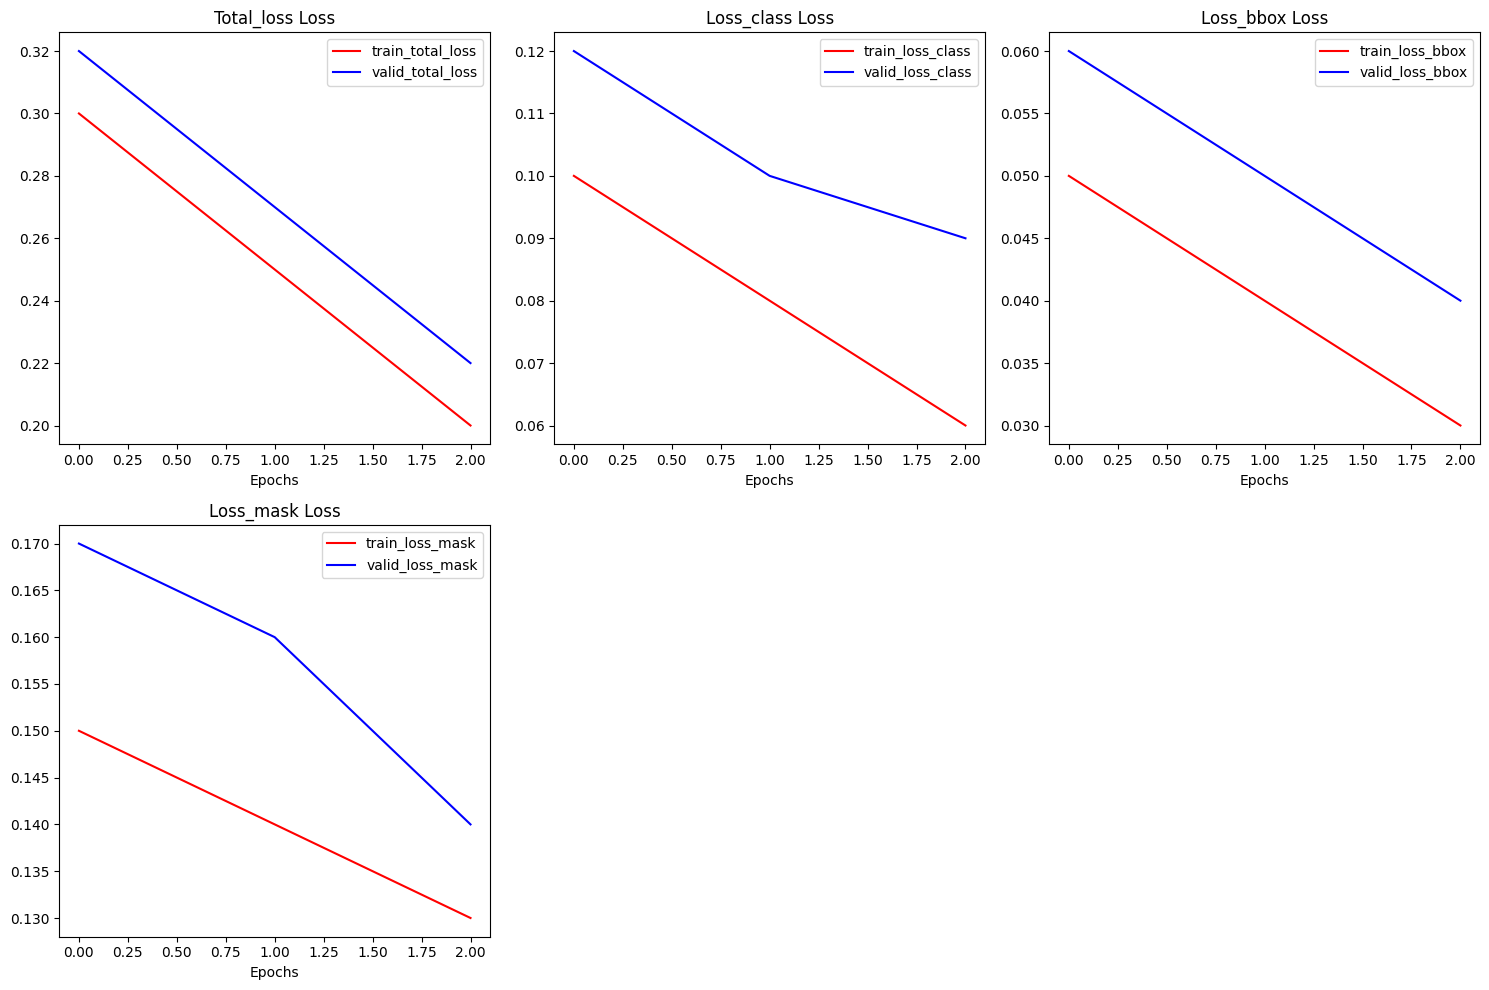

In [ ]:
results_train = [
    {'total_loss': 0.3, 'loss_class': 0.1, 'loss_bbox': 0.05, 'loss_mask': 0.15},
    {'total_loss': 0.25, 'loss_class': 0.08, 'loss_bbox': 0.04, 'loss_mask': 0.14},
    {'total_loss': 0.2, 'loss_class': 0.06, 'loss_bbox': 0.03, 'loss_mask': 0.13}
]

results_valid = [
    {'total_loss': 0.32, 'loss_class': 0.12, 'loss_bbox': 0.06, 'loss_mask': 0.17},
    {'total_loss': 0.27, 'loss_class': 0.1, 'loss_bbox': 0.05, 'loss_mask': 0.16},
    {'total_loss': 0.22, 'loss_class': 0.09, 'loss_bbox': 0.04, 'loss_mask': 0.14}
]

losses = ['total_loss', 'loss_class', 'loss_bbox', 'loss_mask']

plot_loss_values(results_train, results_valid, losses)


## 1.3 Hyperparameters

Basic configuration for this model

In [ ]:
n_folds = 5
seed = 42
num_classes = 4
num_queries = 800
null_class_coef = 0.5
BATCH_SIZE = 2
LR_DETR = 1e-5
LR_DETR_SEG = 1e-5
EPOCHS_DETR = 20
EPOCHS_DETR_SEG = 50
OWN_MASK_HEAD = True
DEBUG = False
DEBUG_Train = False


In [ ]:
BASE_PATH = "dataset/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 0, "cort": 1, "shsy5y": 2}
DICT_TO_CELL = {0: "astro", 1: "cort", 2: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed_everything(seed)

#2.Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

##2.1.Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [ ]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),

                      A.VerticalFlip(p=0.5),

                      A.Resize(height=512, width=512, p=1),

                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## 2.2 Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [ ]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms


    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # DETR takes in data in coco format
        boxes = records[['x', 'y', 'w', 'h']].values

        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']


        #Normalizing BBOXES

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

In [ ]:

def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        # Check if any of the normalized values are greater than 1
        if any(coord > 1 for coord in normalized_bbox):
            print(f"Normalized values greater than 1 detected: {normalized_bbox}")

        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes

In [ ]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [ ]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [ ]:
import collections
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score

# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score
import torch
from torchvision.transforms import functional as F
from pathlib import Path
import zipfile
import gdown

import collections
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.ops import box_convert, generalized_box_iou

In [ ]:


class ImageCellDataset(Dataset):
    def __init__(self, directory_path, data_frame, transformation_steps=None):
        self.transformation_steps = transformation_steps
        self.directory_path = directory_path
        self.data_frame = data_frame
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.cells_data = collections.defaultdict(dict)

        grouped_df = self.data_frame.groupby(['id', 'cell_type'])['annotation'].apply(list).reset_index()

        for idx, record in grouped_df.iterrows():
            self.cells_data[idx] = {
                'cell_id': record['id'],
                'file_path': os.path.join(self.directory_path, record['id'] + '.png'),
                'cell_annotations': record["annotation"],
                'type': CELL_TYPE_DICT[record["cell_type"]]
            }


    # get the item and load annotations (mask) accordingly
    def __getitem__(self, index):
        cell_data = self.cells_data[index]
        image_file = cell_data["file_path"]
        image = Image.open(image_file).convert("RGB")
        num_objects = len(cell_data['cell_annotations'])
        masks = np.zeros((num_objects, self.img_height, self.img_width), dtype=np.uint8)
        bounding_boxes = []

        for i, annotation in enumerate(cell_data['cell_annotations']):
            decoded_mask = decode_rle(annotation, (self.img_height, self.img_width))
            decoded_mask = Image.fromarray(decoded_mask)
            decoded_mask = np.array(decoded_mask) > 0
            masks[i, :, :] = decoded_mask
            box = find_bounding_box(decoded_mask)

            bounding_boxes.append(box)


        # Prepare labels based on cell type
        labels = [cell_data["type"] for _ in range(num_objects)]

        # Convert bounding_boxes from Corner Points Format to CXCW format
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor




        # print(f"Bounding box initial: {bounding_boxes[0]}")

        # print(f"Bounding box after convertion: {bounding_boxes[0]}")
        #bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        cell_id_tensor = torch.tensor([index])
        areas = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * (bounding_boxes[:, 2] - bounding_boxes[:, 0])
        not_crowded = torch.zeros((num_objects,), dtype=torch.int64)

        target_dict = {
            'boxes': bounding_boxes,
            'labels': labels,
            'masks': masks,
            'image_id': cell_id_tensor,
            'area': areas,
            'iscrowd': not_crowded
            # 'file_path': image_file
        }


        if self.transformation_steps:
            image, target_dict = self.transformation_steps(image, target_dict)

        # do normalization and conversation here
        boxes = target_dict['boxes']
        converted_boxes = torch.zeros_like(boxes)

        for i, box in enumerate(boxes):
            converted_boxes[i] = box_convert(box, in_fmt='xyxy', out_fmt='cxcywh')
            #print(converted_boxes[i])
        bounding_boxes = converted_boxes
        bounding_boxes = normalize_bbox(bounding_boxes,rows=520,cols=704)
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor


        target_dict['boxes'] = bounding_boxes
        return image, target_dict

    def __len__(self):
        return len(self.cells_data)


# 3.Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from torch import Tensor

class MHAttentionMap(nn.Module):
    """This is a 2D attention module, which only returns the attention softmax (no multiplication by value)"""

    def __init__(self, query_dim, hidden_dim, num_heads, dropout=0.0, bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout)

        self.q_linear = nn.Linear(query_dim, hidden_dim, bias=bias)
        self.k_linear = nn.Linear(query_dim, hidden_dim, bias=bias)

        nn.init.zeros_(self.k_linear.bias)
        nn.init.zeros_(self.q_linear.bias)
        nn.init.xavier_uniform_(self.k_linear.weight)
        nn.init.xavier_uniform_(self.q_linear.weight)
        self.normalize_fact = float(hidden_dim / self.num_heads) ** -0.5

    def forward(self, q, k, mask: Optional[Tensor] = None):
        q = self.q_linear(q)
        k = F.conv2d(k, self.k_linear.weight.unsqueeze(-1).unsqueeze(-1), self.k_linear.bias)
        qh = q.view(q.shape[0], q.shape[1], self.num_heads, self.hidden_dim // self.num_heads)
        kh = k.view(k.shape[0], self.num_heads, self.hidden_dim // self.num_heads, k.shape[-2], k.shape[-1])
        weights = torch.einsum("bqnc,bnchw->bqnhw", qh * self.normalize_fact, kh)

        if mask is not None:
            weights.masked_fill_(mask.unsqueeze(1).unsqueeze(1), float("-inf"))
        weights = F.softmax(weights.flatten(2), dim=-1).view(weights.size())
        weights = self.dropout(weights)
        return weights

In [ ]:

def _expand(tensor, length: int):
    return tensor.unsqueeze(1).repeat(1, int(length), 1, 1, 1).flatten(0, 1)
from typing import List, Optional

class MaskHeadSmallConv(nn.Module):
    """
    Simple convolutional head, using group norm.
    Upsampling is done using a FPN approach
    """

    def __init__(self, dim, fpn_dims, context_dim):
        super().__init__()

        inter_dims = [dim, context_dim // 2, context_dim // 4, context_dim // 8, context_dim // 16, context_dim // 64]
        self.lay1 = torch.nn.Conv2d(dim, dim, 3, padding=1)
        self.gn1 = torch.nn.GroupNorm(8, dim)
        self.lay2 = torch.nn.Conv2d(dim, inter_dims[1], 3, padding=1)
        self.gn2 = torch.nn.GroupNorm(8, inter_dims[1])
        self.lay3 = torch.nn.Conv2d(inter_dims[1], inter_dims[2], 3, padding=1)
        self.gn3 = torch.nn.GroupNorm(8, inter_dims[2])
        self.lay4 = torch.nn.Conv2d(inter_dims[2], inter_dims[3], 3, padding=1)
        self.gn4 = torch.nn.GroupNorm(8, inter_dims[3])
        self.lay5 = torch.nn.Conv2d(inter_dims[3], inter_dims[4], 3, padding=1)
        self.gn5 = torch.nn.GroupNorm(8, inter_dims[4])
        self.out_lay = torch.nn.Conv2d(inter_dims[4], 1, 3, padding=1)

        self.dim = dim

        self.adapter1 = torch.nn.Conv2d(fpn_dims[0], inter_dims[1], 1)
        self.adapter2 = torch.nn.Conv2d(fpn_dims[1], inter_dims[2], 1)
        self.adapter3 = torch.nn.Conv2d(fpn_dims[2], inter_dims[3], 1)
        self.upsample_to_target = nn.Upsample(size=(520, 704), mode='bilinear', align_corners=False)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x: Tensor, bbox_mask: Tensor, fpns: List[Tensor]):
        x = torch.cat([_expand(x, bbox_mask.shape[1]), bbox_mask.flatten(0, 1)], 1)
        #print("Concat layer", x.shape)
        x = self.lay1(x)
        x = self.gn1(x)
        x = F.relu(x)
        x = self.lay2(x)
        x = self.gn2(x)
        x = F.relu(x)
        #print("Upsamling 0: " ,fpns[0].shape)
        cur_fpn = self.adapter1(fpns[0])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay3(x)
        x = self.gn3(x)
        x = F.relu(x)
        #print("Upsamling 1: ", fpns[1].shape)
        cur_fpn = self.adapter2(fpns[1])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay4(x)
        x = self.gn4(x)
        x = F.relu(x)
        #print("Upsamling 2: ", fpns[2].shape)
        cur_fpn = self.adapter3(fpns[2])
        if cur_fpn.size(0) != x.size(0):
            cur_fpn = _expand(cur_fpn, x.size(0) // cur_fpn.size(0))
        x = cur_fpn + F.interpolate(x, size=cur_fpn.shape[-2:], mode="nearest")
        x = self.lay5(x)
        x = self.gn5(x)
        x = F.relu(x)

        x = self.out_lay(x)
        x  = self.upsample_to_target(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UpdatedSimplifiedMaskHead(nn.Module):
    def __init__(self, input_dim, fpn_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim + 1, input_dim // 2, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_dim // 2, input_dim // 4, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(input_dim // 4, 1, kernel_size=1)
        self.upsample_to_target = nn.Upsample(size=(520, 704), mode='bilinear', align_corners=False)

    def forward(self, x, bbox_masks, fpn_features):
        batch_size, num_queries, _, height, width = bbox_masks.size()
        output_masks = []

        for i in range(num_queries):
            # Process each query's bbox mask individually
            bbox_mask = bbox_masks[:, i, :, :, :]
            # Average across the 8 channels of the bbox_mask
            bbox_mask = bbox_mask.mean(dim=1, keepdim=True)
            bbox_mask_upsampled = F.interpolate(bbox_mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
            x_with_mask = torch.cat([x, bbox_mask_upsampled], dim=1)

            x1 = self.conv1(x_with_mask)
            x1 = self.relu(x1)
            x1 = self.conv2(x1)
            x1 = self.relu(x1)
            mask = self.final_conv(x1)
            mask = self.upsample_to_target(mask)
            output_masks.append(mask)

        # Stack all masks to match the batch and queries size
        output_masks = torch.stack(output_masks, dim=1)  # Shape will be [batch_size, num_queries, 1, 130, 176]
        return output_masks


In [ ]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # Load the pre-trained DETR model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)


        # Change the number of queries by adjusting the query embedding matrix
        self.model.query_embed = nn.Embedding(self.num_queries, self.model.transformer.d_model)

        # Adjust the class embedding layer to the number of classes
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        hidden_dim = 256  # Example value, adjust as necessary
        self.mask_head = MaskHeadSmallConv(hidden_dim + 1, hidden_dim, num_queries)  # Adjust +1 based on concatenated attn map

    def forward(self, images):
        return self.model(images)

In [ ]:
from detr.util.misc import NestedTensor, interpolate, nested_tensor_from_tensor_list

class DETRPanopticModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRPanopticModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # Load the pre-trained DETR model for panoptic segmentation
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=True)

        # Change the number of queries by adjusting the query embedding matrix
        self.model.detr.query_embed = nn.Embedding(self.num_queries, self.model.detr.transformer.d_model)

        # # Adjust the class embedding layer to the number of classes for the detection head
        self.in_features = self.model.detr.class_embed.in_features
        self.model.detr.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)

        hidden_dim, nheads = self.model.detr.transformer.d_model, self.model.detr.transformer.nhead
        self.bbox_attention = MHAttentionMap(hidden_dim, hidden_dim, nheads, dropout=0.0)
        #self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)
        hidden_dim = 256
        fpn_dims = [1024, 512, 256]
        if OWN_MASK_HEAD:
          self.mask_head = UpdatedSimplifiedMaskHead(hidden_dim, fpn_dims) #--> own mask head
        else:
          self.mask_head = MaskHeadSmallConv(hidden_dim + nheads, [1024, 512, 256], hidden_dim)


        hidden_dim = 256  # Example hidden_dim from DETR model
        fpn_dims = [1024, 512, 256]  # Example FPN dimensions
        num_queries = 100  # Example number of queries
        #self.mask_head = MaskHeadSmallConv2(hidden_dim, fpn_dims, num_queries)

    def forward(self, images):
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features,pos   = self.model.detr.backbone(images)
        if DEBUG:
          print("Type of backbone features is: ", len(features) )
          print("Shape of backbone features is: ", features[3].tensors.shape) #torch.Size([2, 256, 130, 176]) 256 = embedding / channel
        # 4 index because of 4 outputs layers of detr
        # index1: torch.Size([2, 256, 130, 176])
        # index2: torch.Size([2, 512, 65, 88])
        # index3: torch.Size([2, 1024, 33, 44])
          #print("Shape of backbone features is: ", features[2].tensors)
          print("Shape of backbone features is: ", features[2].mask.shape) #torch.Size([2, 130, 176])
          #print("Shape of backbone features is: ", features[2].mask) #True/False masks
          print("Shape of backbone pos is: ", len(pos) )
          print("Shape of backbone pos is: ", pos[3].shape )

        bs = features[-1].tensors.shape[0]
        if DEBUG:
          print("Shape of backbone bs is: ", bs )
        src, mask = features[-1].decompose()
        if DEBUG:
          print("Shape of backbone src is: ", src.shape )
          print("Shape of backbone mask is: ", mask.shape )
        assert mask is not None
        src_proj = self.model.detr.input_proj(src)
        if DEBUG:
          print("Shape of backbone src_proj is: ", src_proj.shape )
          print("query embeddings weight ", self.model.detr.query_embed.weight.shape)
        hs, memory = self.model.detr.transformer(src_proj, mask, self.model.detr.query_embed.weight, pos[-1])
        if DEBUG:
          print("Shape of transformer hs  is: ", hs.shape )
          print("Shape of transformer memory  is: ", memory.shape )

        outputs_class = self.model.detr.class_embed(hs)
        if DEBUG:
          print("Shape of outputs_class   is: ", outputs_class.shape )

        outputs_coord = self.model.detr.bbox_embed(hs).sigmoid()
        if DEBUG:
          print("Shape of outputs_coord   is: ", outputs_coord.shape )

        out = {"pred_logits": outputs_class[-1], "pred_boxes": outputs_coord[-1]}
        if self.model.detr.aux_loss:
            out['aux_outputs'] = self.model.detr._set_aux_loss(outputs_class, outputs_coord)

        # FIXME h_boxes takes the last one computed, keep this in mind
        bbox_mask = self.bbox_attention(hs[-1], memory, mask=mask)
        if DEBUG:
          print("Shape of bbox_mask   is: ", bbox_mask.shape )
          print("Shape of x for mask head input is: ", src_proj.shape )
          print(f"Shape fpn_features input is: of array 0:{features[2].tensors.shape} 1:{features[1].tensors.shape} 2:{features[0].tensors.shape}")
        #seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        hidden_dim = 256  # Example hidden dimension from the DETR model
        fpn_dims = [1024, 512, 256]  # Example FPN dimensions from ResNet-50 backbone
        bbox_dim = 1  # Dimension of the bounding box mask feature
        if OWN_MASK_HEAD:
          seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        else:
          seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])

        outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])

        #seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors]) comment in for own
        if DEBUG:
          print("Shape of seg_masks   is: ", seg_masks.shape)
        #outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1]) comment in for own
        if DEBUG:
          print("Shape final masks  is: ", outputs_seg_masks.shape)
        # seg_masks = self.mask_head(src_proj, bbox_mask, [features[2].tensors, features[1].tensors, features[0].tensors])
        # outputs_seg_masks = seg_masks.view(bs, self.model.detr.num_queries, seg_masks.shape[-2], seg_masks.shape[-1])
        out["pred_masks"] = outputs_seg_masks
        return out

## 3.1 Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [ ]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [ ]:
def transform_targets(targets):
    # Initialize the new list structure
    targets_new = []

    # Assuming all lists in 'targets' are of the same length
    for i in range(len(next(iter(targets.values())))):  # Iterate through the length of any list in 'targets'
        # Construct new dict for each index, pulling the corresponding item from each list in 'targets'
        new_dict = {key: value[i] for key, value in targets.items()}
        targets_new.append(new_dict)

    return targets_new

## 3.2 Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch, train_segmentation=False):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()
    # Temporary storage for accumulating loss values
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)

    # Dictionary to store average epoch loss values for plotting later
    results_train = defaultdict(float)
    # Verify settings
    # for name, param in model.named_parameters():
    #     print(name, param.requires_grad)


    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        for key in list(targets.keys()):
          if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
              targets[key] = [item.to(device) for item in targets[key]]
        #print("Input Shape: ", images[0].shape)
        #print("Input Data: ", images[0])
        output = model(images)

        #print("Output  boxes: ", output['pred_boxes'])


        targets_new = transform_targets(targets)

        #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        #print(output['pred_logits'].shape)
        probabilities = torch.sigmoid(output['pred_logits'])
        # Find the indices of the max probabilities
        max_indices = torch.argmax(probabilities, dim=-1)
        # Check how often the max index is not the last index (index 3)
        not_last_index_count = torch.sum(max_indices != (4 - 1))
        num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
        missing_objects = num_objects_gt-not_last_index_count
        #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )


        loss_dict = criterion(output, targets_new)
        weight_dict = criterion.weight_dict


               # Initialize losses as None to dynamically set it later
        losses = None
        if train_segmentation:
          if DEBUG_Train:
            print("masks are:" , output['pred_masks'].shape)
            print(loss_dict.items())
            print("Loss mask: ", loss_dict['loss_mask'])
            print("Loss dice: ", loss_dict['loss_dice'])

        for k, loss_value in loss_dict.items():
            if k in weight_dict and loss_value.requires_grad:
                weighted_loss = loss_value * weight_dict[k]
                epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                loss_counts[k] += 1
                if losses is None:
                    losses = weighted_loss
                else:
                    losses += weighted_loss

        #print(f"Loss are: {losses}")

        # Ensure losses is not None and has gradients before proceeding
        if losses is None or not losses.requires_grad:
            print("Warning: No gradients in any loss components; nothing to backpropagate.")
            continue
        # # Print requires_grad for each loss component


        # #losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # # Sum only losses that have gradients
        # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict and loss_dict[k].requires_grad)


        #print(f"Loss requires grad: {losses.requires_grad}")  # Check if loss requires gradients

        optimizer.zero_grad()
        if not losses.requires_grad:
          raise ValueError("No gradients in loss computation; check loss inputs.")


        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        #print( print(epoch_losses))
        # for k in epoch_losses:
        #   if loss_counts[k] > 0:
        #       results_train[k].append(epoch_losses[k] / loss_counts[k])
        #print( print(epoch_losses))

    results_train['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_train[k] = epoch_losses[k]/ loss_counts[k]

    return summary_loss, dict(results_train)



## 3.3 Eval Function

In [ ]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)

    # Dictionary to store average epoch loss values for plotting later
    results_valid = defaultdict(float)

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            for key in list(targets.keys()):
              if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
                  targets[key] = [item.to(device) for item in targets[key]]

            output = model(images)
            targets_new = transform_targets(targets)

            #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
            probabilities = torch.sigmoid(output['pred_logits'])
            # Find the indices of the max probabilities
            max_indices = torch.argmax(probabilities, dim=-1)
            # Check how often the max index is not the last index (index 3)
            not_last_index_count = torch.sum(max_indices != (4 - 1))
            num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
            missing_objects = num_objects_gt-not_last_index_count
            #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

            loss_dict = criterion(output, targets_new)
            weight_dict = criterion.weight_dict

            losses = None
            for k, loss_value in loss_dict.items():
              if k in weight_dict:
                  weighted_loss = loss_value * weight_dict[k]
                  epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                  loss_counts[k] += 1
                  if losses is None:
                      losses = weighted_loss
                  else:
                      losses += weighted_loss

            if losses is None:
              print("Warning: No gradients in any loss components; nothing to backpropagate.")
              continue

            # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

            # for k in epoch_losses:
            #   if loss_counts[k] > 0:
            #       results_valid[k].append(epoch_losses[k] / loss_counts[k])

    results_valid['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_valid[k] = epoch_losses[k]/ loss_counts[k]
    return summary_loss, dict(results_valid)





In [ ]:
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
def prepare_for_coco_segmentation(predictions_masks, predictions_logits, targets_labels, targets_masks):
    annotation_id = 1  # Unique ID for each annotation
    coco_predictions = []
    coco_targets = []
    for image_id, ((prediction_masks, prediction_logits), (target_labels, target_masks)) in enumerate(zip(zip(predictions_masks, predictions_logits), zip(targets_labels, targets_masks))):
        print(f"Image Id: {image_id}")
        # Get scores and labels
        pred_scores = prediction_logits.softmax(-1).max(-1)[0].cpu().numpy()
        pred_labels = prediction_logits.softmax(-1).max(-1)[1].cpu().numpy() + 1
        print("pred labels shape", pred_labels.shape)
        print("pred labels: ", pred_labels)
        # Convert prediction masks to COCO format
        limit_objects = 0
        for mask, score, label in zip(prediction_masks.cpu().numpy(), pred_scores, pred_labels):
            if limit_objects < 5:
              # Applying sigmoid to convert outputs to [0, 1] range
              mask_prob = sigmoid(mask)
              # print(label.shape)
              mask_binary = (mask_prob > 0.5).astype(np.uint8)
              if np.any(mask_binary) and label != 4:  # Check if the mask is not entirely zero
                  rle = encode(np.asfortranarray(mask_binary))
                  if rle:  # Ensure rle is not None
                      rle_str = base64.b64encode(rle['counts']).decode()  # Encode and convert to string
                      #print(rle_str)# Create coco annotation predciction for every mask
                      coco_pred = {
                          'image_id': image_id,
                          'category_id': int(label),
                          'segmentation': {'size': rle['size'], 'counts': rle_str},
                          'score': float(score),
                          'id': annotation_id
                      }
                      coco_predictions.append(coco_pred)
                      annotation_id += 1
              limit_objects += 1


        print(f"Len of annotations is {len(coco_predictions)}")
        # Convert ground truth masks to COCO format
        for mask, label in zip(target_masks.cpu().numpy(), target_labels.cpu().numpy()):
            mask_binary = (mask > 0.5).astype(np.uint8)
            if np.any(mask_binary):  # Check if the mask is not entirely zero
                rle = encode(np.asfortranarray(mask_binary))
                if rle:  # Ensure rle is not None
                    rle_str = base64.b64encode(rle['counts']).decode()
                    coco_gt = {
                        'image_id': image_id,
                        'category_id': int(label) + 1,
                        'segmentation': {'size': rle['size'], 'counts': rle_str},
                        'area': int(np.sum(mask_binary)),
                        'iscrowd': 0,
                        'id': annotation_id
                    }
                    coco_targets.append(coco_gt)
            annotation_id += 1

    return coco_predictions, coco_targets


### Coco Eval Method

In [ ]:
import numpy as np
import base64
from pycocotools.mask import encode, decode
import torch
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
import numpy as np
import base64
from scipy.special import expit as sigmoid  # Importing sigmoid function
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode
from pycocotools.mask import toBbox

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def prepare_for_coco_segmentation(predictions_masks, predictions_logits, target_labels, target_masks, start_annotation_id=1, image_id_outside=1):
    annotation_id = start_annotation_id  # Start from the passed ID
    coco_predictions = []
    coco_targets = []
    prediction_logits = predictions_logits[0]
    prediction_masks = predictions_masks[0]

    # Convert logits to probabilities and then to labels and scores
    pred_scores = prediction_logits.softmax(-1).max(-1)[0].cpu().numpy()
    pred_labels = prediction_logits.softmax(-1).max(-1)[1].cpu().numpy() + 1

    limit_objects = 0
    for mask, score, label in zip(prediction_masks.cpu().numpy(), pred_scores, pred_labels):
        if limit_objects < 500:  # Limit the number of objects processed for simplicity
            mask_prob = sigmoid(mask)
            mask_binary = (mask_prob > 0.5).astype(np.uint8)
            area = np.sum(mask_binary)  # Summing up the 1s in the binary mask
            #print("area of mask" , area)
            if np.any(mask_binary) and label != 4:  # Exclude certain classes if needed
                rle = encode(np.asfortranarray(mask_binary))
                rle['counts'] = rle['counts'].decode('utf-8')  # Decode byte string
                coco_pred = {
                    'image_id': image_id_outside,
                    'category_id': int(label),
                    'segmentation': rle,
                    'score': float(score),
                    'id': annotation_id
                }
                coco_predictions.append(coco_pred)
                annotation_id += 1
            limit_objects += 1

    for mask, label in zip(target_masks.cpu().numpy(), target_labels.cpu().numpy()):
        mask_binary = (mask > 0.5).astype(np.uint8)
        if np.any(mask_binary):
            rle = encode(np.asfortranarray(mask_binary))
            rle['counts'] = rle['counts'].decode('utf-8')
            coco_gt = {
                'image_id': image_id_outside,
                'category_id': int(label) + 1,
                'segmentation': rle,
                'area': int(np.sum(mask_binary)),
                'iscrowd': 0,
                'id': annotation_id
            }
            coco_targets.append(coco_gt)
            annotation_id += 1

    return coco_predictions, coco_targets, annotation_id


In [ ]:
import json

def eval_fn_coco(data_loader, model,criterion, device, train_segmentation=False):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    epoch_losses = defaultdict(float)
    loss_counts = defaultdict(int)
    coco_predictions = []
    coco_targets = []
    coco_predictions_box = []
    coco_targets_box = []
    # Dictionary to store average epoch loss values for plotting later
    results_valid = defaultdict(float)
    annotation_id = 1
    image_id = 0
    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        eval_step = 0
        for step, (images, targets) in enumerate(tk0):
            if eval_step < 10:
              images = list(image.to(device) for image in images)
              for key in list(targets.keys()):
                if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
                    targets[key] = [item.to(device) for item in targets[key]]

              output = model(images)
              targets_new = transform_targets(targets)

              #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
              probabilities = torch.sigmoid(output['pred_logits'])
              # Find the indices of the max probabilities
              max_indices = torch.argmax(probabilities, dim=-1)
              # Check how often the max index is not the last index (index 3)
              not_last_index_count = torch.sum(max_indices != (4 - 1))
              num_objects_gt = targets_new[0]['labels'].shape[0]
              missing_objects = num_objects_gt-not_last_index_count
              #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

              loss_dict = criterion(output, targets_new)
              weight_dict = criterion.weight_dict

              losses = None
              for k, loss_value in loss_dict.items():
                if k in weight_dict:
                    weighted_loss = loss_value * weight_dict[k]
                    epoch_losses[k] += weighted_loss.item()  # Sum weighted losses for averaging
                    loss_counts[k] += 1
                    if losses is None:
                        losses = weighted_loss
                    else:
                        losses += weighted_loss

              if losses is None:
                print("Warning: No gradients in any loss components; nothing to backpropagate.")
                continue

              # losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)


              #Coco dataset eval
              if train_segmentation:
                #print(type(targets['masks']))
                #print(type(targets['masks']))
                pred_coco, gt_coco, annotation_id_result = prepare_for_coco_segmentation(output['pred_masks'], output['pred_logits'], targets['labels'][0], targets['masks'][0],annotation_id, image_id)
                annotation_id = annotation_id_result
                image_id = image_id + 1
                #print(type("Test 2"))
                #pred_coco_box, gt_coco_box = prepare_for_coco_box(output['pred_masks'], output['pred_logits'], targets['labels'], targets['boxes'])
                # coco_predictions_box.extend(pred_coco_box)
                # coco_targets_box.extend(gt_coco_box)
                coco_predictions.extend(pred_coco)
                coco_targets.extend(gt_coco)

              summary_loss.update(losses.item(),BATCH_SIZE)
              tk0.set_postfix(loss=summary_loss.avg)
              eval_step = eval_step + 1

            # for k in epoch_losses:
            #   if loss_counts[k] > 0:
            #       results_valid[k].append(epoch_losses[k] / loss_counts[k])
    #print(type("Test 2"))
    results_valid['total_loss'] = summary_loss.avg
    for k, loss_value in loss_dict.items():
      if loss_counts[k] > 0:
        print(f"Loss value {k} with the final loss {epoch_losses[k]/ loss_counts[k]}")
        results_valid[k] = epoch_losses[k]/ loss_counts[k]

    #print(json.dumps(coco_predictions, indent=4))
    #print("Now targets")
    #print(json.dumps(coco_targets, indent=4))
    if train_segmentation:
        # Define the overall structure for the COCO dataset files
        coco_dataset_predictions = {
            "images": [{"id": idx , "height":520, "width":704 } for idx in range(len(data_loader.dataset))],
            "categories": [
              {
                "id": 1,
                "name": "class1"
              },
              {
                "id": 2,
                "name": "class2"
              },
              {
                "id": 3,
                "name": "class3"
              }
            ],  # Adjust 'num_classes' accordingly
            "annotations": coco_predictions
        }
        coco_dataset_targets = {
           "images": [{"id": idx, "height":520, "width":704 } for idx in range(len(data_loader.dataset))],
            "categories": [
              {
                "id": 1,
                "name": "class1"
              },
              {
                "id": 2,
                "name": "class2"
              },
              {
                "id": 3,
                "name": "class3"
              }
            ],  # Adjust 'num_classes' accordingly
            "annotations": coco_targets
        }

        # Save to JSON files
        with open('temp_coco_predictions.json', 'w') as f:
            json.dump(coco_dataset_predictions, f)
        with open('temp_coco_targets.json', 'w') as f:
            json.dump(coco_dataset_targets, f)

        # Load annotations and predictions
        cocoGt = COCO('temp_coco_targets.json')
        cocoDt = cocoGt.loadRes(coco_predictions)

        # Initialize COCOeval object
        cocoEval = COCOeval(cocoGt, cocoDt, 'segm')
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        # # Precision and recall are available in cocoEval.eval
        # precision = cocoEval.eval['precision']
        # recall = cocoEval.eval['recall']

        # # Assume you have some thresholds or just take mean
        # mean_precision = precision.mean(axis=2)  # Average over IoU thresholds

        # plt.figure(figsize=(7, 5))
        # plt.plot(recall, mean_precision, marker='o')
        # plt.xlabel('Recall')
        # plt.ylabel('Precision')
        # plt.title('Precision-Recall Curve')
        # plt.grid(True)
        # plt.show()





    return summary_loss, dict(results_valid)



In [ ]:
  # cocoGt = COCO('temp_coco_targets.json')
  # cocoDt = cocoGt.loadRes('temp_coco_predictions.json')

#4.Engine Preparation

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from pathlib import Path
import zipfile
import gdown

# Setup paths and folders names and urls
data_path = Path("dataset")
download_path = Path("kaggledownload")

#dataset_url = 'https://drive.google.com/uc?id=1syZoLGGeFiFErCFL_iI1VO_4k2jLEaPv&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t'


# If the image folder doesn't exist, download it
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)
    download_path.mkdir(parents=True, exist_ok=True)

print("Downloading dataset...")
gdown.download(dataset_url, str(download_path / "sartorius-cell-instance-segmentation.zip"), quiet=False)


Did not find dataset directory, creating one...


Downloading...
From: https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t
To: /content/kaggledownload/sartorius-cell-instance-segmentation.zip
100%|██████████| 2.48G/2.48G [00:23<00:00, 106MB/s]


'kaggledownload/sartorius-cell-instance-segmentation.zip'

In [ ]:
# Unzip data
with zipfile.ZipFile(str(download_path / "sartorius-cell-instance-segmentation.zip"), "r") as zip_ref:
    print("Unzipping train dataset data...")
    zip_ref.extractall(data_path)

Unzipping train dataset data...


In [ ]:
import numpy as np
def decode_rle(rle_string, dimensions, fill_value=1):
  """
  Decodes a run-length encoded string into a binary mask.

  Parameters:
  - rle_string: The run-length encoded string (e.g., "2 3 5 2" means start at 2, length 3, start at 5, length 2)
  - dimensions: Tuple indicating the shape of the output mask (height, width)
  - fill_value: The value to fill the mask with where the RLE indicates; default is 1

  Returns:
  - A 2D numpy array representing the mask, where filled areas are marked with `fill_value` and the rest are 0.
  """

  # Split the RLE string into a list of strings, then convert every string into an integer
  numbers = [int(num) for num in rle_string.split()]

  # Extract start positions and lengths from the list of numbers
  start_positions = numbers[::2]
  lengths = numbers[1::2]

  # Calculate end positions for each run
  end_positions = [start + length for start, length in zip(start_positions, lengths)]

  # Initialize a flat image array with zeros
  flat_image = np.zeros(dimensions[0] * dimensions[1], dtype=np.float32)

  # Fill the specified positions in the flat image array
  for start, end in zip(start_positions, end_positions):
      flat_image[start:end] = fill_value

  # Reshape the flat image array back into the specified dimensions
  return flat_image.reshape(dimensions)

import numpy as np

def encode_rle(image_matrix):
  """
  Encodes a binary image matrix into a run-length encoding string.

  Parameters:
  - image_matrix: A 2D numpy array representing the image to be encoded. Expected to contain binary values (0s and 1s).

  Returns:
  - A string representing the run-length encoded image, where each pair of numbers represents a start position and the length of consecutive 1s.
  """

  # Find indices of all 1s in the flattened image array
  one_positions = np.where(image_matrix.flatten() == 1)[0]

  # Initialize the list to hold the encoding
  encoding = []

  # Track the previous position to determine the start of a new run
  previous_position = -2

  # Iterate through all positions of 1s
  for position in one_positions:
      # If current position is not consecutive, start a new run
      if position > previous_position + 1:
          encoding.extend((position + 1, 0))  # +1 for 1-based indexing
      encoding[-1] += 1  # Increment the length of the current run
      previous_position = position

  # Join all elements in the list as a string separated by spaces
  return ' '.join(map(str, encoding))

def eliminate_overlaps(primary_mask, additional_masks):
  """
  Removes pixels from the primary mask where it overlaps with any of the additional masks.

  Parameters:
  - primary_mask: A 2D numpy array representing the primary mask to be modified.
  - additional_masks: A list of 2D numpy arrays, each representing a mask to check for overlaps with the primary mask.

  Returns:
  - The modified primary mask with overlapping pixels set to 0.
  """

  # Iterate through each of the additional masks
  for mask in additional_masks:
      # Find overlapping pixels between the primary mask and the current additional mask
      overlap = np.logical_and(primary_mask, mask)

      # Check if there is any overlap
      if np.sum(overlap) > 0:
          # Set overlapping pixels in the primary mask to 0
          primary_mask[overlap] = 0

  # Return the modified primary mask
  return primary_mask

import numpy as np

def create_boxed_image(coordinates):
    """
    Draws a rectangular box on an image represented by a numpy array, based on given coordinates.

    Parameters:
    - coordinates: A list of four elements representing the box's corners [xmin, ymin, xmax, ymax].

    Returns:
    - A 2D numpy array (image) with dimensions IMG_HEIGHT x IMG_WIDTH,
      where pixels inside the box are set to 1, and the rest are 0.
    """

    # Initialize a blank image with zeros
    image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Extract and convert the box coordinates to integers
    xmin, ymin, xmax, ymax = map(int, coordinates)

    # Draw top and bottom lines of the box
    for x in range(xmin, xmax):
        if xmin != 0 and xmax != IMG_WIDTH:  # Check to prevent drawing outside the image
            image[ymin-1][x] = 1  # Draw top line
            image[ymax-1][x] = 1  # Draw bottom line

    # Draw left and right lines of the box
    for y in range(ymin, ymax):
        if ymin != 0 and ymax != IMG_HEIGHT:  # Check to prevent drawing outside the image
            image[y][xmax-1] = 1  # Draw right line
            image[y][xmin-1] = 1  # Draw left line

    # Return the image with the drawn box
    return image

import numpy as np

def find_bounding_box(mask):
    """
    Calculates the bounding box of a non-zero area in a mask.

    Parameters:
    - mask: A 2D numpy array representing the mask from which to calculate the bounding box.

    Returns:
    - A list containing the coordinates of the bounding box: [xmin, ymin, xmax, ymax].
    """

    # Find the indices of non-zero elements in the mask
    nonzero_indices = np.where(mask)

    # Calculate the minimum and maximum x (column) indices
    left_bound = np.min(nonzero_indices[1])
    right_bound = np.max(nonzero_indices[1])

    # Calculate the minimum and maximum y (row) indices
    top_bound = np.min(nonzero_indices[0])
    bottom_bound = np.max(nonzero_indices[0])

    # Return the bounding box coordinates
    return [left_bound, top_bound, right_bound, bottom_bound]

def merge_masks(mask_list, threshold):
    """
    Merges multiple masks into a single image, assigning a unique integer to each mask's area based on its order in the list,
    but only for mask values above a specified threshold.

    Parameters:
    - mask_list: A list of 2D numpy arrays (masks) to be merged. Each mask should have the same dimensions.
    - threshold: A value that defines the minimum intensity for pixels to be considered part of a mask.

    Returns:
    - A 2D numpy array where each pixel's value corresponds to the order of the mask it belongs to,
      or 0 if it does not belong to any mask or does not meet the threshold.
    """

    # Initialize an empty image with the same dimensions as the masks
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Iterate through each mask with its order starting from 1
    for order, mask in enumerate(mask_list, 1):
        # Update the combined image with the order number where the mask exceeds the threshold
        #print(order)
        #print(mask.shape)
        combined_image[mask > threshold] = order

    return combined_image

import numpy as np

def merge_masks_and_boxes(mask_image, box_image):
    """
    Combines mask and box images into one, ensuring that the boxes overlay the masks and
    have the highest value present in the mask image.

    Parameters:
    - mask_image: A 2D numpy array representing multiple masks, where non-zero values indicate mask presence.
    - box_image: A 2D numpy array representing multiple boxes, marked as 1's for box edges and 0's for the background.

    Returns:
    - A 2D numpy array where both boxes and masks are combined. Boxes will overlay masks with the highest mask value found.
    """

    # Initialize a result image with zeros
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Find the highest value in the mask_image
    max_mask_value = np.max(mask_image)

    # First pass: Copy mask values to the combined image
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            combined_image[y, x] = mask_image[y, x]

    # Second pass: Overlay boxes on the combined image, setting them to the highest mask value
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            if box_image[y, x] != 0:  # If there's a box pixel, overlay it with the max mask value
                combined_image[y, x] = max_mask_value

    return combined_image

In [ ]:
# transformation functions

# Adjustments to PyTorch transformation classes to accommodate masks and targets
# Inspired by Abishek and DATAISTA0's approach

import torch
import random
from torchvision.transforms import functional as TF

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

class FlipVertically:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-2)
            box = label["boxes"]
            box[:, [1, 3]] = pic_height - box[:, [3, 1]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-2)
        return pic, label

class FlipHorizontally:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-1)
            box = label["boxes"]
            box[:, [0, 2]] = pic_width - box[:, [2, 0]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-1)
        return pic, label





class Normalize:
    """Normalize tensor image with mean and standard deviation."""
    def __call__(self, pic, label):
        pic = TF.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
        return pic, label

class ConvertToTensor:
    """Convert PIL Image or numpy.ndarray to Tensor."""
    def __call__(self, pic, label):
        # Ensure pic is converted to a tensor using torchvision's functional API
        pic = TF.to_tensor(pic)
        return pic, label




def get_transforms(training):
    base_transforms = [ConvertToTensor()]
    if training:
        # Augmentations for the training dataset
        augmentations = [
            FlipHorizontally(likelihood=0.5),  # Assuming a 50% chance to apply
            FlipVertically(likelihood=0.5),  # Assuming a 50% chance to apply
        ]
        base_transforms.extend(augmentations)

    # Always apply normalization last
    base_transforms.append(Normalize())

    return Compose(base_transforms)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets


# Load your dataset DataFrame
df_train = pd.read_csv(TRAIN_CSV)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Initialize your full dataset with transformations
#full_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))

train_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))
valid_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_val, transformation_steps=get_transforms(training=False))


valid_dataset_coco = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_val, transformation_steps=get_transforms(training=False))
train_dataset_coco = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=False))



# dl_train_dataset = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)



# # Generate indices and split them
# indices = list(range(len(full_dataset)))
# train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# # Create Subset objects for train and validation sets
# train_subset = Subset(full_dataset, train_indices)
# val_subset = Subset(full_dataset, val_indices)

# Initialize DataLoaders for the train and validation subsets
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
dl_val = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
print(len(valid_dataset_coco))
dl_val_coco = DataLoader(valid_dataset_coco, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
dl_train_coco = DataLoader(train_dataset_coco, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)


600


In [ ]:
print("Val Image len:", len(dl_train))
first_batch = next(iter(dl_train))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)

Val Image len: 303


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([2, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 2


In [ ]:
def set_requires_grad(model, flag):
    for param in model.parameters():
        param.requires_grad = flag


In [ ]:
device = torch.device('cuda')
model = DETRPanopticModel(num_classes=num_classes,num_queries=100)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-panoptic-00ce5173.pth" to /ro

## 4.1 Engine

In [ ]:
import copy

from collections import defaultdict

#optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Set segmentation parameters to not require gradients
set_requires_grad(model.model.bbox_attention, False)
set_requires_grad(model.model.mask_head, False)
set_requires_grad(model.bbox_attention, False)
set_requires_grad(model.mask_head, False)

# Initialize the optimizer with only detection parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_DETR)

EPOCHS_DETR = 30
best_loss = 10**5
total_results_train = []
total_results_valid = []
for epoch in range(EPOCHS_DETR):
    train_loss, results_train = train_fn(dl_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch, train_segmentation=False)
    total_results_train.append(copy.deepcopy(results_train))
    valid_loss, results_valid = eval_fn(dl_val, model,criterion, device)
    total_results_valid.append(copy.deepcopy(results_valid))
    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print('Best model found for Fold {} in Epoch {}........Saving Model', epoch+1)
        torch.save(model.state_dict(), f'detr_best_{epoch}.pth')





  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9003227771361275
Loss value loss_bbox with the final loss 0.15534103135562966
Loss value loss_giou with the final loss 0.8060987221427484


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.837929237857461
Loss value loss_bbox with the final loss 0.18076724434892336
Loss value loss_giou with the final loss 1.048358845114708
|EPOCH 1| TRAIN_LOSS 1.8617625248314131| VALID_LOSS 2.0670553290843965|
Best model found for Fold {} in Epoch {}........Saving Model 1


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.58112334934595
Loss value loss_bbox with the final loss 0.11624834462754403
Loss value loss_giou with the final loss 0.708967513672196


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8057790731887022
Loss value loss_bbox with the final loss 0.16348458979278802
Loss value loss_giou with the final loss 1.0216757931311926
|EPOCH 2| TRAIN_LOSS 1.4063392088751587| VALID_LOSS 1.9909394613901774|
Best model found for Fold {} in Epoch {}........Saving Model 2


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.5288431961519686
Loss value loss_bbox with the final loss 0.11144799882970234
Loss value loss_giou with the final loss 0.6936290331012739


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8502952869112292
Loss value loss_bbox with the final loss 0.17312168162936967
Loss value loss_giou with the final loss 0.9838346948226293
|EPOCH 3| TRAIN_LOSS 1.3339202296812542| VALID_LOSS 2.0072516616185507|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.4778778107019246
Loss value loss_bbox with the final loss 0.10485322298266904
Loss value loss_giou with the final loss 0.6773964935305095


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.7837734107797345
Loss value loss_bbox with the final loss 0.14287663410107296
Loss value loss_giou with the final loss 0.9414161051313082
|EPOCH 4| TRAIN_LOSS 1.2601275250266488| VALID_LOSS 1.8680661489566168|
Best model found for Fold {} in Epoch {}........Saving Model 4


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.48445521181498474
Loss value loss_bbox with the final loss 0.10225159970570122
Loss value loss_giou with the final loss 0.6951318352234246


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9332774208237727
Loss value loss_bbox with the final loss 0.15726153654356798
Loss value loss_giou with the final loss 0.9974808406829834
|EPOCH 5| TRAIN_LOSS 1.2818386496687093| VALID_LOSS 2.088019801179568|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.4283874947024454
Loss value loss_bbox with the final loss 0.10663490101277041
Loss value loss_giou with the final loss 0.6925445081967332


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8102715456734101
Loss value loss_bbox with the final loss 0.13721982156857848
Loss value loss_giou with the final loss 0.927316687007745
|EPOCH 6| TRAIN_LOSS 1.2275669044590627| VALID_LOSS 1.8748080535729725|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.4203850598913608
Loss value loss_bbox with the final loss 0.09751156753808161
Loss value loss_giou with the final loss 0.6678476963106161


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 1.0405036928256353
Loss value loss_bbox with the final loss 0.12164020009338855
Loss value loss_giou with the final loss 0.9419484631220499
|EPOCH 7| TRAIN_LOSS 1.1857443228118096| VALID_LOSS 2.104092350800832|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.4058130217736077
Loss value loss_bbox with the final loss 0.08769392451461983
Loss value loss_giou with the final loss 0.6661908945726482


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.93782364902397
Loss value loss_bbox with the final loss 0.121508567823718
Loss value loss_giou with the final loss 0.9166056432326635
|EPOCH 8| TRAIN_LOSS 1.1596978437585799| VALID_LOSS 1.9759378584225973|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.421164990159938
Loss value loss_bbox with the final loss 0.0856623110167756
Loss value loss_giou with the final loss 0.6478004044432057


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.7352071854720513
Loss value loss_bbox with the final loss 0.12415742637589573
Loss value loss_giou with the final loss 0.9901394442717234
|EPOCH 9| TRAIN_LOSS 1.1546277066957045| VALID_LOSS 1.8495040571689605|
Best model found for Fold {} in Epoch {}........Saving Model 9


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.4157623498056625
Loss value loss_bbox with the final loss 0.0926971235635257
Loss value loss_giou with the final loss 0.661252695981032


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8830684968704978
Loss value loss_bbox with the final loss 0.1303340954333544
Loss value loss_giou with the final loss 0.9203358201185862
|EPOCH 10| TRAIN_LOSS 1.1697121716962002| VALID_LOSS 1.9337384108702342|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.40535960083354033
Loss value loss_bbox with the final loss 0.08813112945889089
Loss value loss_giou with the final loss 0.6589876604158886


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.916288644062976
Loss value loss_bbox with the final loss 0.12176032023504377
Loss value loss_giou with the final loss 0.9367396674553553
|EPOCH 11| TRAIN_LOSS 1.1524783872535127| VALID_LOSS 1.9747886367638905|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.37273171702676483
Loss value loss_bbox with the final loss 0.08320260973702563
Loss value loss_giou with the final loss 0.6465421566376985


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8974347484235963
Loss value loss_bbox with the final loss 0.11545441130176187
Loss value loss_giou with the final loss 0.9071200891335806
|EPOCH 12| TRAIN_LOSS 1.102476480770426| VALID_LOSS 1.920009246468544|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3705715852353119
Loss value loss_bbox with the final loss 0.0789829420767995
Loss value loss_giou with the final loss 0.6341459844568775


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9646894619365534
Loss value loss_bbox with the final loss 0.11744934001316627
Loss value loss_giou with the final loss 0.9278907612959544
|EPOCH 13| TRAIN_LOSS 1.0837005118135572| VALID_LOSS 2.0100295718510948|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3805230161699193
Loss value loss_bbox with the final loss 0.08579661130364186
Loss value loss_giou with the final loss 0.6546811724554981


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9440029889717698
Loss value loss_bbox with the final loss 0.11414041712259253
Loss value loss_giou with the final loss 0.9264117566744486
|EPOCH 14| TRAIN_LOSS 1.1210008004907728| VALID_LOSS 1.9845551659663518|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3657020415957839
Loss value loss_bbox with the final loss 0.07692190230802537
Loss value loss_giou with the final loss 0.6361875635857629


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9779648432383935
Loss value loss_bbox with the final loss 0.11568760293225447
Loss value loss_giou with the final loss 0.9113668252031009
|EPOCH 15| TRAIN_LOSS 1.0788115061844143| VALID_LOSS 2.005019274552663|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.37788438457510015
Loss value loss_bbox with the final loss 0.07621598879041352
Loss value loss_giou with the final loss 0.6223094656620876


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8400714116295179
Loss value loss_bbox with the final loss 0.11104961444313327
Loss value loss_giou with the final loss 0.9009526826937994
|EPOCH 16| TRAIN_LOSS 1.076409842757502| VALID_LOSS 1.8520737065871558|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.362831578443208
Loss value loss_bbox with the final loss 0.0743637339553178
Loss value loss_giou with the final loss 0.6173036873537322


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9701597049832344
Loss value loss_bbox with the final loss 0.13059368144099912
Loss value loss_giou with the final loss 0.9250651903947195
|EPOCH 17| TRAIN_LOSS 1.0544989958356317| VALID_LOSS 2.02581857919693|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.35439552869932056
Loss value loss_bbox with the final loss 0.07389323238787478
Loss value loss_giou with the final loss 0.6101889331938803


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8995924098541339
Loss value loss_bbox with the final loss 0.11241706412285567
Loss value loss_giou with the final loss 0.9039379797379176
|EPOCH 18| TRAIN_LOSS 1.0384776976340675| VALID_LOSS 1.9159474468231201|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3552416541733512
Loss value loss_bbox with the final loss 0.07172686803975317
Loss value loss_giou with the final loss 0.61419311544486


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8627641275152564
Loss value loss_bbox with the final loss 0.1004166775693496
Loss value loss_giou with the final loss 0.8963060417771339
|EPOCH 19| TRAIN_LOSS 1.0411616372983448| VALID_LOSS 1.8594868483146032|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.34809003164876473
Loss value loss_bbox with the final loss 0.06841349566091012
Loss value loss_giou with the final loss 0.6056703780055439


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 1.0118480177223683
Loss value loss_bbox with the final loss 0.1052110415076216
Loss value loss_giou with the final loss 0.8884482517838478
|EPOCH 20| TRAIN_LOSS 1.0221739036611992| VALID_LOSS 2.0055073070526124|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.33852430086017343
Loss value loss_bbox with the final loss 0.07192353333466418
Loss value loss_giou with the final loss 0.6080568960987696


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8813281912729144
Loss value loss_bbox with the final loss 0.10249620513990522
Loss value loss_giou with the final loss 0.8852200075984001
|EPOCH 21| TRAIN_LOSS 1.0185047316767595| VALID_LOSS 1.8690444028377533|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3346577075482177
Loss value loss_bbox with the final loss 0.07336102243475985
Loss value loss_giou with the final loss 0.6201715773776812


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 1.051691742017865
Loss value loss_bbox with the final loss 0.12236967088654638
Loss value loss_giou with the final loss 0.9280609685182571
|EPOCH 22| TRAIN_LOSS 1.0281903035078113| VALID_LOSS 2.1021223912636438|


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.33073354639703095
Loss value loss_bbox with the final loss 0.07337106148967452
Loss value loss_giou with the final loss 0.6138768928869329


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9126581036671996
Loss value loss_bbox with the final loss 0.12226735130573313
Loss value loss_giou with the final loss 0.9185593883196513
|EPOCH 23| TRAIN_LOSS 1.017981502285885| VALID_LOSS 1.9534848433732988|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3572012679751274
Loss value loss_bbox with the final loss 0.07224353520574645
Loss value loss_giou with the final loss 0.61658080364808


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 1.0518888668343425
Loss value loss_bbox with the final loss 0.10991177343452971
Loss value loss_giou with the final loss 0.8893755647540093
|EPOCH 24| TRAIN_LOSS 1.0460256054358121| VALID_LOSS 2.051176208257675|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Loss value loss_ce with the final loss 0.34079887853972246
Loss value loss_bbox with the final loss 0.07036839545437015
Loss value loss_giou with the final loss 0.6013014897359873


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8602965895086527
Loss value loss_bbox with the final loss 0.10978614471231897
Loss value loss_giou with the final loss 0.8862858908375104
|EPOCH 25| TRAIN_LOSS 1.0124687649826012| VALID_LOSS 1.8563686217864355|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.3397878607279366
Loss value loss_bbox with the final loss 0.07264783688307595
Loss value loss_giou with the final loss 0.6078807688487244


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 1.0421804403389494
Loss value loss_bbox with the final loss 0.11403384155283372
Loss value loss_giou with the final loss 0.8970443326234817
|EPOCH 26| TRAIN_LOSS 1.0203164663448585| VALID_LOSS 2.0532586145401|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.31987691289962733
Loss value loss_bbox with the final loss 0.06956203966078782
Loss value loss_giou with the final loss 0.6088669126478359


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.9887176035965483
Loss value loss_bbox with the final loss 0.1110957077331841
Loss value loss_giou with the final loss 0.8998795066277187
|EPOCH 27| TRAIN_LOSS 0.9983058630338203| VALID_LOSS 1.999692812760671|


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.3204181996276356
Loss value loss_bbox with the final loss 0.07136366826485191
Loss value loss_giou with the final loss 0.6089943295756582


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8551384671032429
Loss value loss_bbox with the final loss 0.10245763572553794
Loss value loss_giou with the final loss 0.9002653037508329
|EPOCH 28| TRAIN_LOSS 1.00077619981451| VALID_LOSS 1.8578614034255345|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.33228843253495466
Loss value loss_bbox with the final loss 0.07026245032526282
Loss value loss_giou with the final loss 0.598389946834089


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.93431204157571
Loss value loss_bbox with the final loss 0.13427786418547233
Loss value loss_giou with the final loss 0.9266287701328596
|EPOCH 29| TRAIN_LOSS 1.0009408252369059| VALID_LOSS 1.9952186805009842|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.41291850281605746
Loss value loss_bbox with the final loss 0.07359322541925085
Loss value loss_giou with the final loss 0.6081632689969374


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853077719609
Loss value loss_bbox with the final loss 0.10248805609221259
Loss value loss_giou with the final loss 0.8891230908036232
|EPOCH 30| TRAIN_LOSS 1.0946749959743456| VALID_LOSS 1.8051964581012725|
Best model found for Fold {} in Epoch {}........Saving Model 30


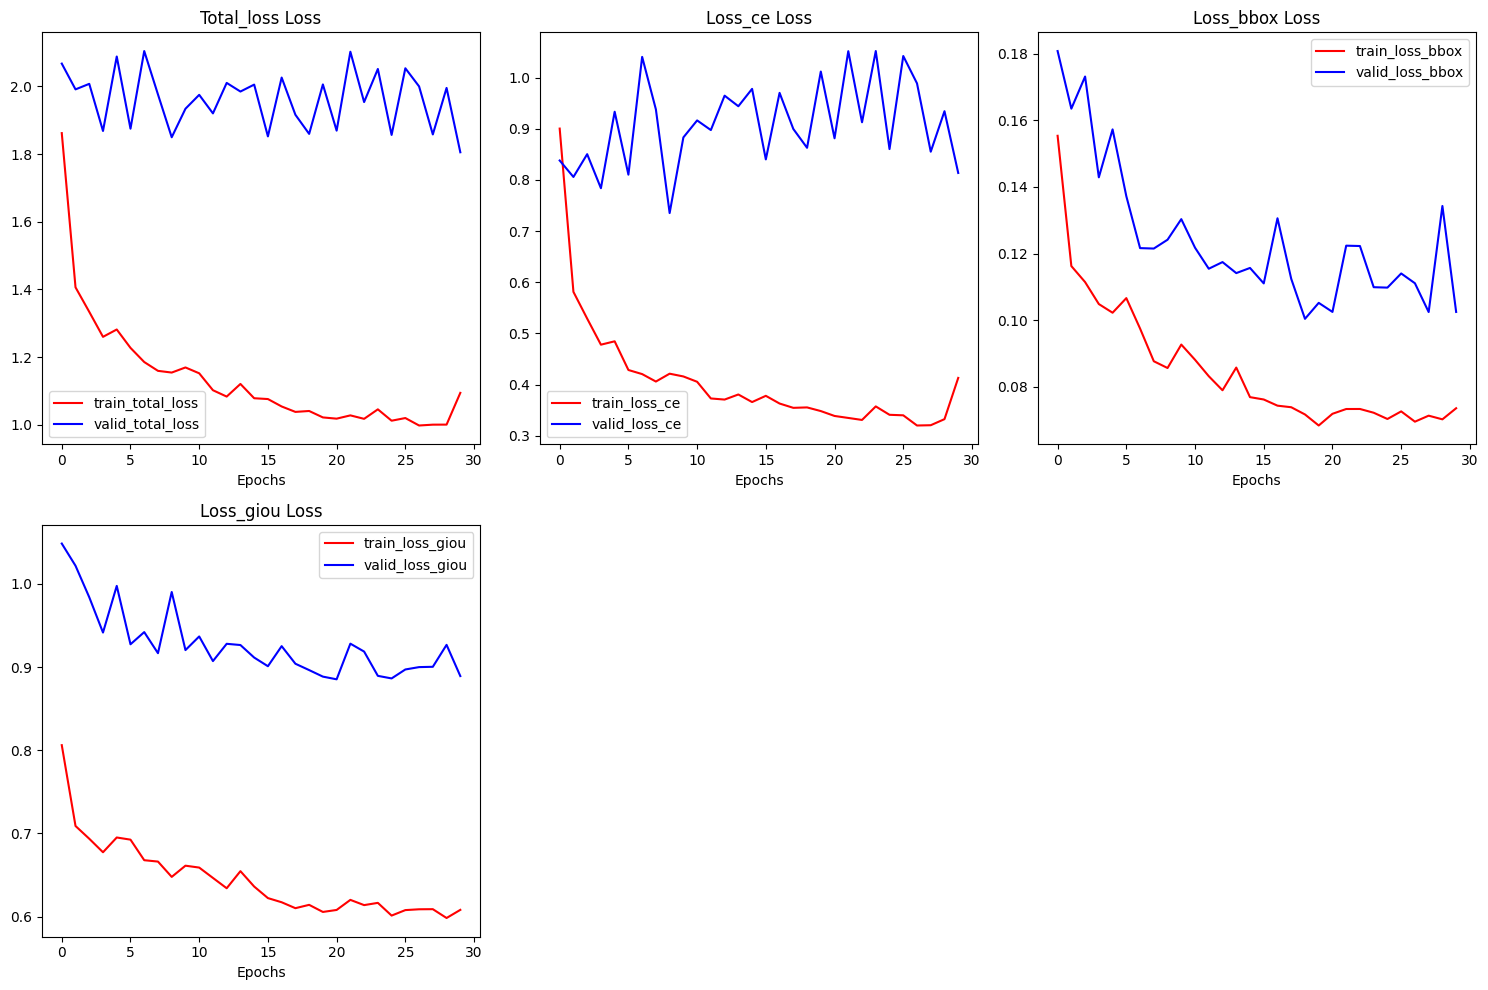

In [ ]:
losses_plot = ['total_loss', 'loss_ce', 'loss_bbox', 'loss_giou']

plot_loss_values(total_results_train, total_results_valid, losses_plot)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda')
LR_DETR_SEG = 1e-4
losses = ['labels', 'boxes', 'cardinality', 'masks']
weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1, 'loss_mask:': 1, 'loss_dice': 1}

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)





#optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Set segmentation parameters to not require gradients



# Set segmentation parameters to not require gradients
set_requires_grad(model.model.bbox_attention, False)
set_requires_grad(model.model.mask_head, False)
set_requires_grad(model.model.detr, False)
set_requires_grad(model.bbox_attention, True)
set_requires_grad(model.mask_head, True)


# Initialize the optimizer with only detection parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_DETR_SEG)

# # Verify settings
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

EPOCHS_DETR_SEG = 50
best_loss = 10**5
total_results_train_seg = []
total_results_valid_seg = []

for epoch in range(EPOCHS_DETR_SEG):
    train_loss ,results_train= train_fn(dl_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch,train_segmentation=True)
    total_results_train_seg.append(copy.deepcopy(results_train))
    valid_loss ,results_valid= eval_fn(dl_val, model,criterion, device)
    total_results_valid_seg.append(copy.deepcopy(results_valid))

    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print('Best model found for Fold {} in Epoch {}........Saving Model', epoch+1)
        torch.save(model.state_dict(), f'detr_best_{epoch}.pth')

  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7458734019558029


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9778745925426483
|EPOCH 1| TRAIN_LOSS 0.7458734019558029| VALID_LOSS 2.7830709318319955|
Best model found for Fold {} in Epoch {}........Saving Model 1


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7566196458666238


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9776457200447718
|EPOCH 2| TRAIN_LOSS 0.7566196458666238| VALID_LOSS 2.782842071056366|
Best model found for Fold {} in Epoch {}........Saving Model 2


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7529626585075958


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9766643478473027
|EPOCH 3| TRAIN_LOSS 0.7529626585075958| VALID_LOSS 2.7818606968720756|
Best model found for Fold {} in Epoch {}........Saving Model 3


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7556946073034809


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9772264454762141
|EPOCH 4| TRAIN_LOSS 0.7556946073034809| VALID_LOSS 2.782422784169515|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7456678326177125


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9767080096403757
|EPOCH 5| TRAIN_LOSS 0.7456678326177125| VALID_LOSS 2.781904359261195|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7394251698019481


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9774966665108998
|EPOCH 6| TRAIN_LOSS 0.7394251698019481| VALID_LOSS 2.7826930081844328|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7561613593754595


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9766336985429128
|EPOCH 7| TRAIN_LOSS 0.7561613593754595| VALID_LOSS 2.781830040216446|
Best model found for Fold {} in Epoch {}........Saving Model 7


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7383321402686658


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9762537841002147
|EPOCH 8| TRAIN_LOSS 0.7383321402686658| VALID_LOSS 2.781450125773748|
Best model found for Fold {} in Epoch {}........Saving Model 8


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7433873639740173


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.976439701517423
|EPOCH 9| TRAIN_LOSS 0.7433873639740173| VALID_LOSS 2.7816360449790953|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7513229121567786


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9760975611209869
|EPOCH 10| TRAIN_LOSS 0.7513229121567786| VALID_LOSS 2.7812939063707987|
Best model found for Fold {} in Epoch {}........Saving Model 10


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7505021709026677


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.976080460747083
|EPOCH 11| TRAIN_LOSS 0.7505021709026677| VALID_LOSS 2.7812768002351125|
Best model found for Fold {} in Epoch {}........Saving Model 11


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7489950685906331


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.975810561577479
|EPOCH 12| TRAIN_LOSS 0.7489950685906331| VALID_LOSS 2.781006909211477|
Best model found for Fold {} in Epoch {}........Saving Model 12


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7456257798195672


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9757105586926142
|EPOCH 13| TRAIN_LOSS 0.7456257798195672| VALID_LOSS 2.7809069081147513|
Best model found for Fold {} in Epoch {}........Saving Model 13


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7520821664986437


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9764571060736974
|EPOCH 14| TRAIN_LOSS 0.7520821664986437| VALID_LOSS 2.7816534515221916|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.749302887090362


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9757309597730637
|EPOCH 15| TRAIN_LOSS 0.749302887090362| VALID_LOSS 2.7809273008505504|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7504736440803351


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9755263300736745
|EPOCH 16| TRAIN_LOSS 0.7504736440803351| VALID_LOSS 2.7807226741313933|
Best model found for Fold {} in Epoch {}........Saving Model 16


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7480149812037402


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9757114547491074
|EPOCH 17| TRAIN_LOSS 0.7480149812037402| VALID_LOSS 2.7809078057607013|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7418762149393755


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9758234298229218
|EPOCH 18| TRAIN_LOSS 0.7418762149393755| VALID_LOSS 2.781019777854284|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7472987598908616


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9761796802282333
|EPOCH 19| TRAIN_LOSS 0.7472987598908616| VALID_LOSS 2.781376020908356|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7495152036053906


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9759988602002462
|EPOCH 20| TRAIN_LOSS 0.7495152036053906| VALID_LOSS 2.781195205052694|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7484759742965793


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9756246924400329
|EPOCH 21| TRAIN_LOSS 0.7484759742965793| VALID_LOSS 2.780821028550466|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7503380338744362


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9759173095226288
|EPOCH 22| TRAIN_LOSS 0.7503380338744362| VALID_LOSS 2.7811136492093405|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7562884910173542


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9759214343627294
|EPOCH 23| TRAIN_LOSS 0.7562884910173542| VALID_LOSS 2.7811177766323087|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7455009711850987


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9762313691775004
|EPOCH 24| TRAIN_LOSS 0.7455009711850987| VALID_LOSS 2.781427712440491|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7443937697131248


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9758227487405141
|EPOCH 25| TRAIN_LOSS 0.7443937697131248| VALID_LOSS 2.781019093195597|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7555093408712853


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9758987883726756
|EPOCH 26| TRAIN_LOSS 0.7555093408712853| VALID_LOSS 2.7810951292514803|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.747546730212646


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9757435355583827
|EPOCH 27| TRAIN_LOSS 0.747546730212646| VALID_LOSS 2.780939881006877|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7470303481758231


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.976520365079244
|EPOCH 28| TRAIN_LOSS 0.7470303481758231| VALID_LOSS 2.7817167083422345|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7474350610090168


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9765220634142557
|EPOCH 29| TRAIN_LOSS 0.7474350610090168| VALID_LOSS 2.781718405087789|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7447587299858383


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9759599862496058
|EPOCH 30| TRAIN_LOSS 0.7447587299858383| VALID_LOSS 2.7811563273270923|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.747340522337668


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9762243837118149
|EPOCH 31| TRAIN_LOSS 0.747340522337668| VALID_LOSS 2.781420738697052|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>AssertionError
Traceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
can only test a child process    
self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Loss value loss_dice with the final loss 0.7429010305467612


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9761456020673116
|EPOCH 32| TRAIN_LOSS 0.7429010305467612| VALID_LOSS 2.7813419548670453|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7441311924666068


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9765553583701452
|EPOCH 33| TRAIN_LOSS 0.7441311924666068| VALID_LOSS 2.781751699844996|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7481242063710398


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9760650128126145
|EPOCH 34| TRAIN_LOSS 0.7481242063710398| VALID_LOSS 2.781261358658473|


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.756497668501961


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9764551508426667
|EPOCH 35| TRAIN_LOSS 0.756497668501961| VALID_LOSS 2.7816515044371286|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.747245724051699


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9770688301324845
|EPOCH 36| TRAIN_LOSS 0.747245724051699| VALID_LOSS 2.7822651831309|


  0%|          | 0/303 [00:00<?, ?it/s]

Loss value loss_dice with the final loss 0.7454212889714603


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9767625578244528
|EPOCH 37| TRAIN_LOSS 0.7454212889714603| VALID_LOSS 2.7819589058558147|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7384445320064872


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9763600558042527
|EPOCH 38| TRAIN_LOSS 0.7384445320064872| VALID_LOSS 2.781556397676468|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7459676959628713


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.976361158490181
|EPOCH 39| TRAIN_LOSS 0.7459676959628713| VALID_LOSS 2.7815575035413107|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7478820253225049


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9769259929656983
|EPOCH 40| TRAIN_LOSS 0.7478820253225049| VALID_LOSS 2.782122326294581|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7546047470455516


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9767261548837026
|EPOCH 41| TRAIN_LOSS 0.7546047470455516| VALID_LOSS 2.7819224993387857|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers


    assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7466723893341844


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9763056596120199
|EPOCH 42| TRAIN_LOSS 0.7466723893341844| VALID_LOSS 2.7815019992987313|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.741053585958953


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9769542302687962
|EPOCH 43| TRAIN_LOSS 0.741053585958953| VALID_LOSS 2.782150579293569|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7494673608454934


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9765547094742457
|EPOCH 44| TRAIN_LOSS 0.7494673608454934| VALID_LOSS 2.781751051743825|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7489888861824577


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9767547434568405
|EPOCH 45| TRAIN_LOSS 0.7489888861824577| VALID_LOSS 2.7819510833422343|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7494941350847187


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9768732551733653
|EPOCH 46| TRAIN_LOSS 0.7494941350847187| VALID_LOSS 2.782069603204727|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7474484015809427


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9767875524361929
|EPOCH 47| TRAIN_LOSS 0.7474484015809427| VALID_LOSS 2.781983895699183|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7489315376620088


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9763699295123418
|EPOCH 48| TRAIN_LOSS 0.7489315376620088| VALID_LOSS 2.7815662741661074|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.75281524584435


  0%|          | 0/300 [00:00<?, ?it/s]

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9768444176514943
|EPOCH 49| TRAIN_LOSS 0.75281524584435| VALID_LOSS 2.7820407632986703|


  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_dice with the final loss 0.7466856035167234


  0%|          | 0/300 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bdb7b6c4ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Loss value loss_ce with the final loss 0.8135853018860022
Loss value loss_bbox with the final loss 0.10248803891862432
Loss value loss_giou with the final loss 0.8891230064630509
Loss value loss_dice with the final loss 0.9777751217285792
|EPOCH 50| TRAIN_LOSS 0.7466856035167234| VALID_LOSS 2.782971465587616|


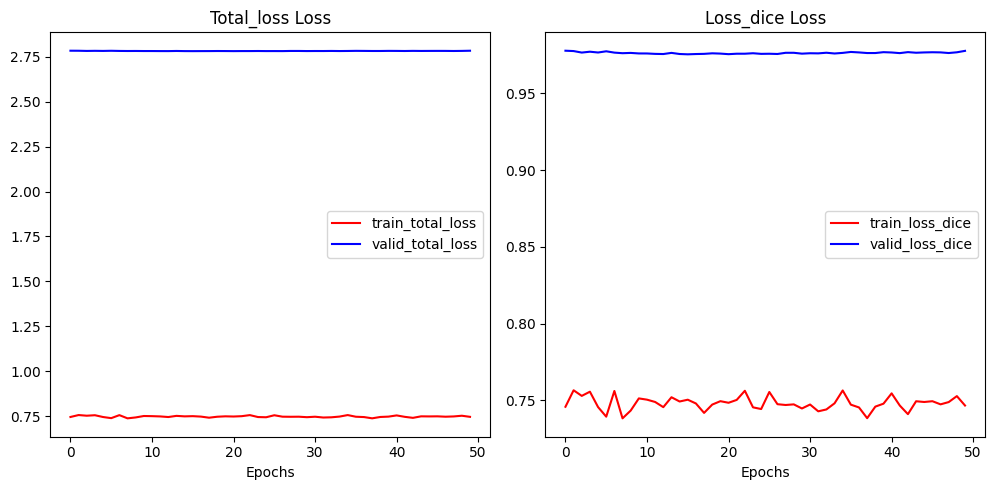

In [ ]:
losses_plot = ['total_loss',  'loss_dice']

plot_loss_values(total_results_train_seg, total_results_valid_seg, losses_plot)

## 4.2 Engine Coco Eval

In [ ]:


device = torch.device('cuda')
losses = ['labels', 'boxes', 'cardinality', 'masks']
weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1, 'loss_mask:':1, 'loss_dice': 1}

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

valid_loss, results_valid = eval_fn_coco(dl_val, model,criterion, device, train_segmentation=True)
#print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))



  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-52-30c891e4f40a>:20: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Loss value loss_ce with the final loss 0.8535149157047272
Loss value loss_bbox with the final loss 0.10147592164576054
Loss value loss_giou with the final loss 0.9490970492362976
Loss value loss_dice with the final loss 0.9928176939487457
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets

# 5.Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [ ]:
def filter_boxes(predictions):
    filtered_masks = []
    boxes = predictions["pred_boxes"].squeeze()
    logits = predictions["pred_logits"].squeeze()
    #print("box shape is ", boxes.shape)
    # Compute probabilities using softmax on logits for each class (excluding the no-element class if it's the last one)
    probabilities = torch.softmax(logits, dim=-1)

    for index, (box, prob) in enumerate(zip(boxes, probabilities)):
        max_prob, max_index = torch.max(prob, dim=0)  # Get the max probability and the corresponding class index
        if max_index != 3:  # Assuming class index 3 is 'no-label found'
            if max_prob > 0.5:  # Replace 0.5 with the minimum score threshold for this class if you have a dict
                box_array = box.cpu().numpy().squeeze()  # Convert the box to a numpy array and remove extra dimensions
                #print("box array shape is : ", box_array.shape)
                #print("box array is : ", box_array)
                #high_confidence_mask = box_array > MASK_THRESHOLD_DICT[max_index.item()]  # Threshold for this class
                #high_confidence_mask = eliminate_overlaps(box_array, filtered_masks)
                #print("high_confidence_mask shape is : ", box_array.shape)
                #print("high_confidence_mask is : ", box_array)
                filtered_masks.append(box_array)

    print(len(filtered_masks))
    return filtered_masks

In [ ]:
def filter_masks(predictions_logits, prediction_maks):
    filtered_masks = []
    masks = prediction_maks.squeeze()
    logits = predictions_logits.squeeze()
    #print("box shape is ", boxes.shape)
    # Compute probabilities using softmax on logits for each class (excluding the no-element class if it's the last one)
    probabilities = torch.softmax(logits, dim=-1)

    for index, (mask, prob) in enumerate(zip(masks, probabilities)):
        max_prob, max_index = torch.max(prob, dim=0)  # Get the max probability and the corresponding class index
        if max_index != 3:  # Assuming class index 3 is 'no-label found'
            if max_prob > 0.5:  # Replace 0.5 with the minimum score threshold for this class if you have a dict
                box_array = mask.cpu().numpy().squeeze()  # Convert the box to a numpy array and remove extra dimensions
                #print("box array shape is : ", box_array.shape)
                #print("box array is : ", box_array)
                #high_confidence_mask = box_array > MASK_THRESHOLD_DICT[max_index.item()]  # Threshold for this class
                #high_confidence_mask = eliminate_overlaps(box_array, filtered_masks)
                #print("high_confidence_mask shape is : ", box_array.shape)
                #print("high_confidence_mask is : ", box_array)
                filtered_masks.append(box_array)

    print(len(filtered_masks))
    return filtered_masks

In [ ]:
def denormalize_and_convert_bbox(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xywh for COCO
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        xywh_bbox = [x_min, y_min, w_denorm, h_denorm]

        denormalized_converted_bboxes.append(xywh_bbox)
    return denormalized_converted_bboxes


def denormalize_and_convert_bbox_xyxy(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xyxy
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        x_max = cx_denorm + (w_denorm / 2)
        y_max = cy_denorm + (h_denorm / 2)
        xyxy_bbox = [x_min, y_min, x_max, y_max]

        denormalized_converted_bboxes.append(xyxy_bbox)


    return denormalized_converted_bboxes

100
100


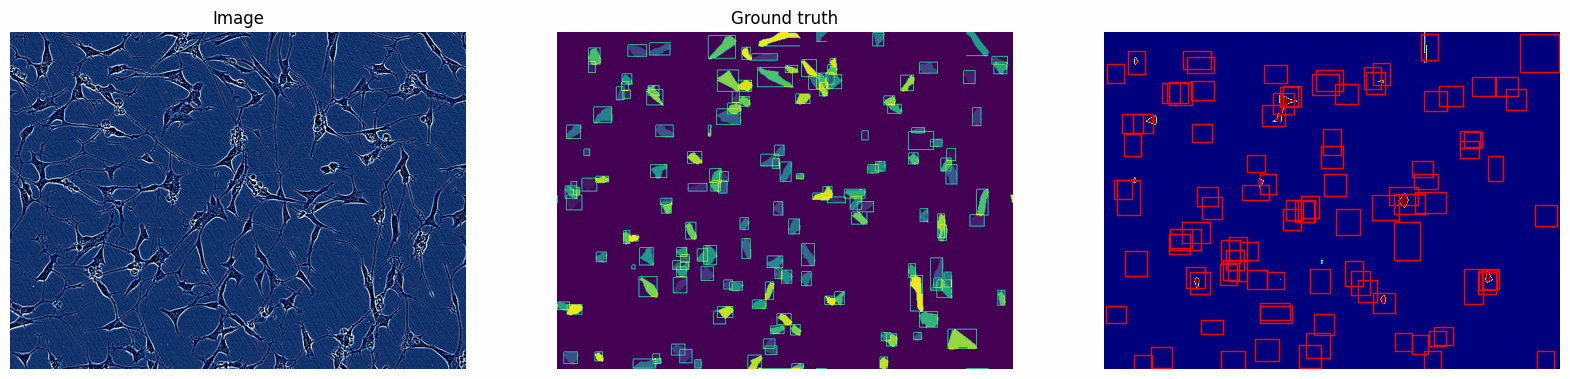

In [ ]:
 #Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import random



def add_boxes(ax, boxes, color='red'):
    """Add bounding boxes to the plot."""
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

def plot_image_boxes_and_masks(image, boxes, masks, ax=None, mask_alpha=0.5, box_color='red'):
    """
    Plot an image with overlaid masks and bounding boxes.

    Args:
    - image: The image as a NumPy array.
    - boxes: A list of [xmin, ymin, xmax, ymax] boxes.
    - masks: A binary mask array of shape [num_masks, height, width].
    - ax: Matplotlib axis object to plot on.
    - mask_alpha: Transparency level of the masks.
    - box_color: Color for the bounding boxes.
    """
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 8))

    # Show the image
    ax.imshow(image)

    # Overlay masks
    for mask in masks:
        ax.imshow(mask, cmap='jet', alpha=mask_alpha)  # 'jet' gives a distinctive color to the mask

    # Add boxes
    add_boxes(ax, boxes, color=box_color)

    ax.axis('off')  # Hide the axes ticks
    plt.show()


def apply_sigmoid_and_threshold(masks, threshold=0.5):
    # Convert logits to probabilities
    probabilities = torch.sigmoid(masks)
    # Apply threshold
    binary_masks = (probabilities > threshold).float()
    return binary_masks


def analyze_sample(model, ds_train, sample_index):
    '''
    model : model used to create the masks/boxes of the object detection
    ds_train : data set to take samples from
    sample_index: index of the image that will be used
    Returns grid 1x3 with : the image | the image + the ground truth mask + detection boxes | the image + the predicted mask + predicted boxes
    '''





    for i, batch in enumerate(dl_train, start=1):
      if i < 200:
        images, targets = batch


        #print(f"Training Image {targets['file_path'][0]}")

        # img, targets = ds_train[sample_index]
        # img_input = img.unsqueeze(0)
        img = images[0]
        img_1 = img.unsqueeze(dim=0)
        img_input = img_1.to(device)
        with torch.no_grad():
          #print(img_input.shape)

          preds = model(img_input)
          #print("Boxes are: ", preds['pred_boxes'])
          #print("Maks  are: ", preds['pred_masks'])

          probabilities = torch.sigmoid(preds['pred_logits'])
          # Find the indices of the max probabilities
          max_indices = torch.argmax(probabilities, dim=-1)
          #print(max_indices)
          not_last_index_count = torch.sum(max_indices != (4 - 1))
          #print("targets type ", type(targets['labels']) )
          #print("targets len ", len(targets['labels']) )
          num_objects_gt = targets['labels'][0].shape[0]
          #num_objects_gt = targets['labels'].shape[0]
          missing_objects = num_objects_gt-not_last_index_count
          #print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )
          binary_masks = apply_sigmoid_and_threshold(preds['pred_masks'])
          #print(preds['pred_logits'])
          filtered_preds = filter_boxes(preds)  # This should filter based on scores or other criteria
          filtered_masks = filter_masks(preds['pred_logits'], binary_masks)
          #print("Filtered Boxes are: ", filtered_preds)
          #print("Filtered Maks are: ", filtered_masks)
          # Convert boxes from normalized to pixel scale
          pred_boxes_original = denormalize_and_convert_bbox_xyxy(filtered_preds, img.shape[1], img.shape[2])
          seg_masks = filtered_masks  # Assuming this contains raw logits from the mask head
          #print("Segmasks are: " ,seg_masks)



          #print(len(pred_boxes_original))
          #for index, box in enumerate(pred_boxes_original):
            #print(f"Box number: {index} ha values {box}")


          if not_last_index_count.item() > 5 and not_last_index_count.item() < 800 :
            break




    #print(pred_boxes_original)
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe")

    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")





    for mask in targets['masks'][0]:
        box = find_bounding_box(mask)
        boxes = np.logical_or(boxes, create_boxed_image(box))

    masks = merge_masks(targets['masks'][0], 0.5)
    #masks = merge_masks(targets['masks'], 0.5)
    detections = merge_masks_and_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")
    #print("masks have shape",targets['masks'][0].shape)
    #print("masks have shape",targets['masks'][0][0])


    plot_image_boxes_and_masks(img.cpu().numpy().transpose((1,2,0)), pred_boxes_original, filtered_masks, ax=axs[2])
    # axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))
    # axs[2].imshow(img.numpy().transpose(1, 2, 0))
    # add_boxes(axs[2], pred_boxes_original, color='red')



    axs[2].set_title("Image with Predicted Boxes")
    axs[2].axis("off")
    plt.show()
analyze_sample(model, train_dataset, 404)